## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data Setup



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



In [5]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

In [6]:
Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
Tanzania_Data = '1tlNUxe2hY2DAOsv6u7R7yC_CiBcr05cXXQiRWBlEHEo'
Senegal_Data = '1cCszXB2Irc1Dp9zyIQgeu4OVWy9ZqvJbTielK8h9PLk'
Mali_Data = '1FnbKj5gwoAQb0QSunBQmyExHwaiLEAdAFCxL59SWLyg'

In [7]:
mali_sheet_names = {
        "expenditures": "Food Expenditures (2018-19)",
        "prices": "Food Prices (2018-19)",
        "household": "Household Characteristics"
    }

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [8]:
def load_country_data(sheet_key, sheet_names = None):

    if sheet_names == None:
        sheet_names = {
        "expenditures": "Food Expenditures (2019-20)",
        "prices": "Food Prices (2019-20)",
        "household": "Household Characteristics"
        }

    # Read expenditures
    x = read_sheets(sheet_key, sheet=sheet_names["expenditures"])
    x = x.set_index(['i','t','m','j']).squeeze()

    # Read prices
    p = read_sheets(sheet_key, sheet=sheet_names["prices"]).set_index(['t','m','j','u'])
    p = p.groupby(['t','m','j','u']).median()  # Median price
    p.index = p.index.set_levels(p.index.levels[-1].str.lower(), level='u')

    p = p.xs('kg', level='u').squeeze().unstack('j')  # Just kg prices
    common_goods = p.columns.intersection(x.index.levels[-1])
    p = p[common_goods].T


    # Read household characteristics
    d = read_sheets(sheet_key, sheet=sheet_names["household"])
    d.columns.name = 'k'
    d = d.replace(np.nan, 0)  # Fill blanks with zero

    #filter data
    

    # Process expenditures
    x = x.T.groupby(['i','t','m','j']).sum()
    x = x.replace(0, np.nan)  # Replace zero with missing
    y = np.log(x)  # Take logs

    d.set_index(['i','t','m'], inplace=True)

    return x, y, p, d


In [42]:
x_uganda, y_uganda, p_uganda, d_uganda = load_country_data(Uganda_Data)
x_tanzania, y_tanzania, p_tanzania, d_tanzania = load_country_data(Tanzania_Data)
x_mali, y_mali, p_mali, d_mali = load_country_data(Mali_Data, sheet_names = mali_sheet_names)
x_senegal, y_senegal, p_senegal, d_senegal = load_country_data(Senegal_Data)
d_senegal = d_senegal.drop(columns = ["men", "women", "girls", "boys"])

Here are household characteristics $d$ of each of the 4 countries



In [43]:
d_uganda.head(2)

,,k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,
0007d1f1449242feb5a25429644fb991,2019-20,Northern,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.609438
0010cbae3cea4ec9831f6cd92b02dc16,2019-20,Northern,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.098612


In [44]:
d_tanzania.head(2)

k                                Males 00-03  Females 00-03  Males 04-08  \
i        t       m                                                         
0001-001 2012-13 Mainland Rural            0              0            0   
         2014-15 Mainland Rural            0              0            0   

k                                Females 04-08  Males 09-13  Females 09-13  \
i        t       m                                                           
0001-001 2012-13 Mainland Rural              0            0              0   
         2014-15 Mainland Rural              0            0              0   

k                                Males 14-18  Females 14-18  Males 19-30  \
i        t       m                                                         
0001-001 2012-13 Mainland Rural            0              0            4   
         2014-15 Mainland Rural            0              0            1   

k                                Females 19-30  Males 31-50  Females 31-50  \
i        t       m                                                           
0001-001 2012-13 Mainland Rural              0            0              0   
         2014-15 Mainland Rural              0            1              0   

k                                Males 51-99  Females 51-99  log HSize  
i        t       m                                                      
0001-001 2012-13 Mainland Rural            2              2   2.079442  
         2014-15 Mainland Rural            1              1   1.386294

In [45]:
d_mali.head(2)

,,k,F 00-03,F 04-08,F 09-13,F 14-18,F 19-30,F 31-50,F 51+,M 00-03,M 04-08,M 09-13,M 14-18,M 19-30,M 31-50,M 51+,M NA,log HSize,F NA
i,t,m,,,,,,,,,,,,,,,,,
1001,2017-18,Kayes,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.197225,0.0
1002,2017-18,Kayes,3.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.484907,0.0


In [46]:
d_senegal.head(2)

,,k,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,
11011,2018,ziguinchor,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
110110,2018,ziguinchor,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1.386294


# Data Filtering
Our population concerns households with at least one elderly male and female. Based on the data we define elderly as aged 51 and older. 

In [49]:
def filter_data (df, on = ["Females 51-99", "Males 51-99"]):
    df_filtered = df[(df[on[0]] >= 1) & (df[on[1]] >= 1)]
    others_zero = (df_filtered.drop(columns=on) == 0).all(axis=1)
    df_filtered = df_filtered[others_zero]
    return df_filtered

In [47]:
d_uganda_filter = filter_data(d_uganda)
d_tanzania_filter = filter_data(d_tanzania)
d_senegal_filter = filter_data(d_senegal)
d_mali_filter = filter_data(d_mali, on = ["F 51+", "M 51+"])

In [50]:
filter_data(d_senegal)

,,k,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,


Filtered Data Frames

In [34]:
#ALLISON CODE ENDS HERE

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [5]:
y.head()

i                                 t        m         j              
0007d1f1449242feb5a25429644fb991  2019-20  Northern  Beans (dry)         9.392662
                                                     Beef               10.239960
                                                     Beer                9.169518
                                                     Cabbage (green)     6.907755
                                                     Cassava (fresh)     8.294050
Name: Expenditure, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [35]:
from cfe import Regression

result_uganda = Regression(y=y_uganda,d=d_uganda_filter)
result_tanzania = Regression(y=y_tanzania,d=d_tanzania_filter)
result_senegal = Regression(y=y_senegal,d=d_senegal_filter)
result_mali = Regression(y=y_mali,d=d_mali_filter)

And then one line to predict expenditures and estimate most of the things we need:



In [36]:
result_uganda.predicted_expenditures()

i                                 t        m         j                     
0010cbae3cea4ec9831f6cd92b02dc16  2019-20  Northern  Avocado                    4119.705534
                                                     Beans (dry)                4747.971864
                                                     Beef                      13180.049255
                                                     Bread                      2599.796505
                                                     Cabbage (green)            1245.083240
                                                                                   ...     
ffb33b3ededa4019a02be24224ab0440  2019-20  Western   Rice                       7908.216662
                                                     Salt                        635.569225
                                                     Sweet Potatoes (fresh)     6488.652751
                                                     Tea (leaves)                690.786614
    

Now we can compare predicted log expenditures with actual:



<Axes: xlabel='yhat', ylabel='y'>

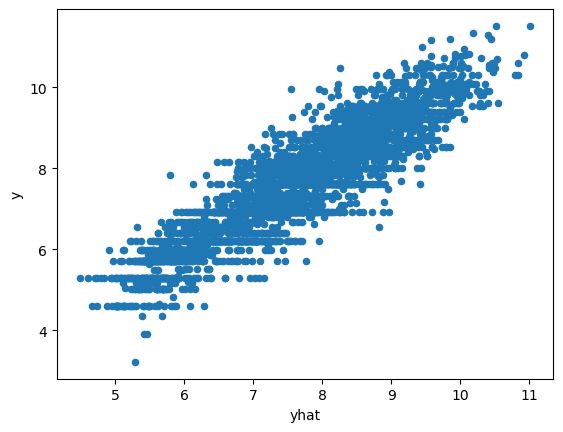

In [37]:
%matplotlib inline
df = pd.DataFrame({'y':y_uganda,'yhat':result_uganda.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



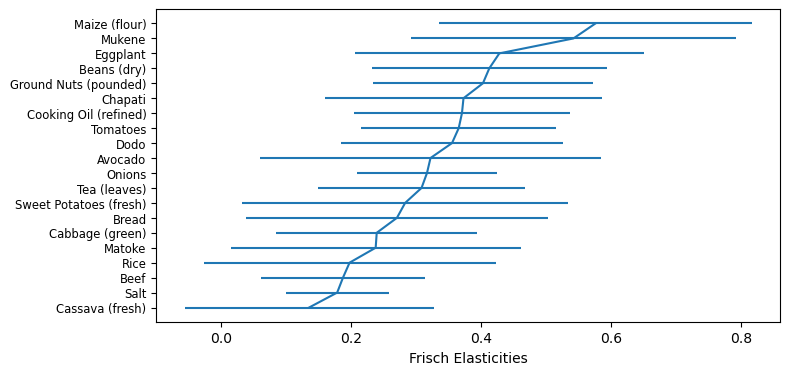

In [38]:
ax = result_uganda.graph_beta()

To just see the values of $\beta$:



In [39]:
result_uganda.get_beta()

j
Avocado                   0.321828
Beans (dry)               0.412247
Beef                      0.187261
Bread                     0.270241
Cabbage (green)           0.239141
Cassava (fresh)           0.135152
Chapati                   0.372579
Cooking Oil (refined)     0.370218
Dodo                      0.354938
Eggplant                  0.427680
Ground Nuts (pounded)     0.402475
Maize (flour)             0.575454
Matoke                    0.237528
Mukene                    0.541662
Onions                    0.316454
Rice                      0.197354
Salt                      0.178333
Sweet Potatoes (fresh)    0.282877
Tea (leaves)              0.308061
Tomatoes                  0.365229
Name: beta, dtype: float64

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [40]:
result_uganda.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Avocado,-0.202280,-0.093281,-0.068885,-0.307492,-0.073108,-0.173442,-0.028709,-0.287261,-0.387996,-0.138400,-0.223360,-0.300034,0.002874,0.289558,1.367796,7.526627
Beans (dry),0.043833,0.210785,0.065371,0.033790,0.044967,0.120157,0.000476,0.028016,0.082650,0.166025,0.149924,0.110037,0.146405,0.456096,0.027449,8.590093
Beef,-0.151102,0.074118,0.163528,-0.142539,0.073277,0.137890,-0.054379,0.013747,0.155512,-0.091985,0.015513,0.141952,0.225200,0.198995,0.032807,9.521031
Bread,-0.411361,0.053706,0.052773,-0.260111,0.162587,-0.017698,0.418270,-0.148922,0.134261,-0.022301,-0.021074,-0.027518,0.343124,0.381367,0.748610,8.361945
Cabbage (green),-0.194244,0.051484,0.059184,-0.033665,0.027183,0.048208,0.062164,-0.238524,-0.018372,-0.205524,0.109740,0.027284,0.004179,-0.170891,0.471289,7.163256
Cassava (fresh),-0.079852,0.007073,-0.021836,-0.051166,0.038221,-0.159515,0.092899,-0.113174,0.251197,0.212464,0.091593,-0.046344,0.435991,0.174467,0.495656,8.283795
Chapati,-0.241835,-0.172278,0.270774,-0.024463,-0.056205,-0.004685,0.038546,0.180356,-0.005063,0.090886,-0.015795,0.135548,-0.034809,-0.098555,0.608219,7.622760
Cooking Oil (refined),-0.157490,-0.180198,0.047979,0.040884,0.002608,0.003831,-0.036005,-0.188017,-0.067447,-0.107462,0.011441,-0.114577,0.130695,-0.051881,0.527296,7.382970
Dodo,-0.058098,0.045315,0.176996,0.023868,0.002515,-0.149205,0.539446,0.094913,-0.010261,0.076966,0.042321,0.149101,0.352282,0.566970,-0.069850,7.426945


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

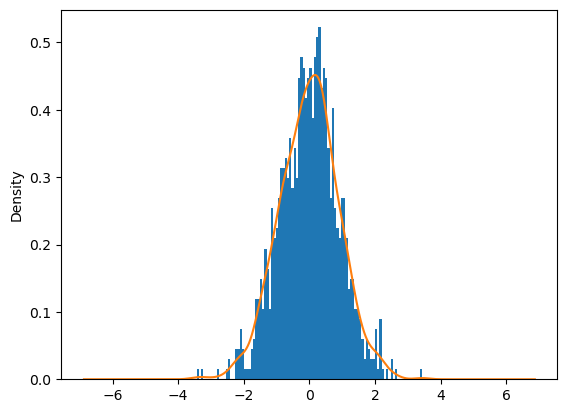

In [30]:
ax = result_uganda.get_w().plot.hist(bins=100,density=True)
result_uganda.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [1]:
result.to_pickle('uganda_estimates.rgsn')

You can subsequently load this using



In [1]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [1]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [1]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Millet Flour'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

##### Engel Curves



Engel curves trace out how demand changes with budget:



In [1]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



In [1]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')